Now we move on to the first nonlinear PDE, which we solve both eliminating variables and relaxing equality constraints, and then applying the Levenberg-Marquardt algorithm. First need to construct differential operators, etc. etc. 

In [89]:
import jax
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax.random as random
from jax import vmap, grad, jacobian

jax.config.update("jax_enable_x64",True)

key = random.key(619420)
key1, key2 = random.split(key)

Burgers' equation is given by $$ \partial_t u  + u \partial_s u  - \nu \partial_s^2 u = 0, \quad (s, t) \in (-1, 1) \times (0, 1]$$ with $$u(s, 0) = \sin(\pi s), \quad u(-1, t) = u(1, t) =0 $$ and take $\nu = 0.002$. 

First define the anisotropic kernel we will be using:

In [90]:
nu = 0.002
SIGMA = jnp.array([1/20, 1/3])

def get_k(sigma):
    def k(x1, x2):
        return jnp.exp(-(1/sigma[0]**2)*(x1[0] - x2[0])**2 - (1/sigma[1]**2)*(x1[1] - x2[1])**2)
    return k

In [91]:
# L represent the functionals, missing composition with evaluation functionals. 
# fun wrt t
def L1(fun, argnums):
    def function(x, y):
        return grad(fun, argnums)(x, y)[1]
    return function

# fun wrt s
def L2(fun, argnums):
    def function(x, y):
        return grad(fun, argnums)(x, y)[0]
    return function

# partial_s^2 fun
def L3(fun, argnums):
    def function(x, y):
        return L2(L2(fun, argnums), argnums)(x, y)
    return function

def L4(fun):
    return fun

# Interior operator
def P(v1, v2, v3, v4):
    return v1 + v4*v2 - nu*v3

# Boundary operator
def B(u1):
    return u1

def get_P_ker(kernel, argnums):
    def curlyP(x1, x2):
        return P(L1(kernel, argnums)(x1, x2), L2(kernel, argnums)(x1, x2), L3(kernel, argnums)(x1, x2), L4(kernel)(x1, x2))
    return curlyP

In [92]:
kernel = get_k(SIGMA)
curlyP = get_P_ker(kernel, argnums=0)
bicurlyP = get_P_ker(curlyP, argnums=1)

vec_k = vmap(vmap(kernel, in_axes = (None,0)), in_axes=(0, None))
vec_curlyP = vmap(vmap(curlyP, in_axes = (None,0)), in_axes=(0, None))
vec_bicurlyP = vmap(vmap(bicurlyP, in_axes = (None,0)), in_axes=(0, None))

The domain is $\Omega = [-1, 1] \times (0, 1]$

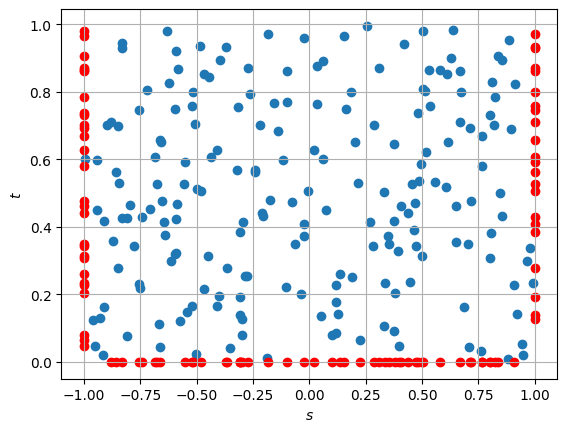

In [ ]:
n_I = 200
n_B = 100
p = 1/2

X_I = jnp.concatenate((2*random.uniform(key1, shape=(n_I, 1)) - 1, random.uniform(key2, shape=(n_I, 1))), axis=1)
bd1 = jnp.concatenate((2*random.bernoulli(key1, p=p, shape=(n_B//2, 1))-1, random.uniform(key2, shape=(n_B//2, 1))), axis=1)
bd2 = jnp.concatenate((2*random.uniform(key1, shape=(n_B//2, 1)) - 1, jnp.zeros(shape=(n_B//2, 1))), axis=1)
X_B = jnp.concatenate((bd1, bd2), axis=0)

plt.scatter(X_I[:, 0], X_I[:, 1])
plt.scatter(X_B[:, 0], X_B[:, 1], color='r')
plt.ylabel('$t$')
plt.xlabel("$s$")
plt.grid()

In [ ]:
f_I = jnp.zeros(X_I.shape[0])
f_B = jnp.concatenate((jnp.zeros(shape=(n_B//2)), jnp.sin(jnp.pi*X_B[:n_B//2, 0])), axis=0)
f = jnp.concatenate((f_I, f_B))


K_II = vec_bicurlyP(X_I, X_I)
K_IB = vec_curlyP(X_I, X_B)
K_BI = K_IB.T
K_BB = vec_k(X_B, X_B)

K = jnp.block([
    [K_II, K_IB],
    [K_BI, K_BB]
])


def F(z):
    # z should have dim (n_B + n_I)
    F_vec = jnp.zeros(z.shape)
    F_vec[:n_I] = vec_curlyP()
    pass

# Working on this lol


Now gotta set up the minimization problem:

$$ \mathrm{minimize}_{z} \hspace{5pt} z^\top K_{\phi, \phi}^{-1} z \quad s.t. \quad F(z) = y$$ 

which we relax to  
$$ \mathrm{minimize}_{z} \hspace{5pt} z^\top K_{\phi, \phi}^{-1} z + \frac{1}{\beta^2} \|F(z) - y\|^2$$ 

and use the LM algorithm. 

In [110]:
def relaxed_LM(K, F ,y, beta, max_iters, x0, tol = 1e-8, reg = 1e-10, verbose = False):
    errs = []
    x = x0
    obj_val = jnp.linalg.norm(F(x) - y)

    errs.append(obj_val)
    for iter in range(max_iters):
        
        Jac = jacobian(F)(x)

        C = Jac.T @ Jac/beta**2+ reg*jnp.eye(len(x))
        x = 1/beta**2 * K @ (Jac.T @ (y - F(x)) - jnp.linalg.solve(jnp.eye(len(x)) + C @ K, K @ Jac.T @ (y - F(x))))

        obj_val = jnp.linalg.norm(F(x) - y)
        errs.append(obj_val)
        if verbose: print(iter, obj_val)
        if obj_val < tol:
            return x, errs

    return x, errs

In [ ]:
x, errs = relaxed_LM(K=K, F = None, y = f, beta = 0.5, max_iters = 1000, )